In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import anndata as ad
import scanpy as sc
import sys
sys.path.append("../../spatial-clust-scripts-main/")
import utils
import os
from tqdm import tqdm
import torch
from skimage.io import imread
from scipy.io import loadmat
from skimage.measure import regionprops
from skimage.transform import resize
import skimage
# import custom functions
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import re
import graph
import seaborn as sns
from skimage.filters import threshold_otsu


In [44]:
df = pd.read_csv('../data/livcan_meta_y4_x69.csv')
df.columns

Index(['RNA_pca_cluster_default', 'RNA_pca_cluster_default.1', 'orig.ident',
       'nCount_RNA', 'nFeature_RNA', 'nCount_negprobes', 'nFeature_negprobes',
       'nCount_falsecode', 'nFeature_falsecode', 'fov', 'Area', 'AspectRatio',
       'Width', 'Height', 'Mean.PanCK', 'Max.PanCK', 'Mean.CK8.18',
       'Max.CK8.18', 'Mean.Membrane', 'Max.Membrane', 'Mean.CD45', 'Max.CD45',
       'Mean.DAPI', 'Max.DAPI', 'cell_id', 'assay_type', 'Run_name',
       'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Mean.Yellow',
       'Max.Yellow', 'Mean.CD298_B2M', 'Max.CD298_B2M', 'cell_ID', 'x_FOV_px',
       'y_FOV_px', 'x_slide_mm', 'y_slide_mm', 'propNegative', 'complexity',
       'errorCtEstimate', 'percOfDataFromError', 'qcFlagsRNACounts',
       'qcFlagsCellCounts', 'qcFlagsCellPropNeg', 'qcFlagsCellComplex',
       'qcFlagsCellArea', 'median_negprobes', 'negprobes_quantile_0.9',
       'median_RNA', 'RNA_quantile_0.9', 'nCell', 'nCount', 'nCountPerCell',
       'nFeaturePerCell', 'propNe

In [45]:
df.loc[:,['cell_ID', 'fov']].head()

,cell_ID,fov
0,c_2_305_59,305
1,c_2_307_104,307
2,c_2_307_148,307
3,c_2_307_375,307
4,c_2_307_409,307


In [46]:
def pad_to_square(img):
    h = img.shape[0]
    w = img.shape[1]
    if h < w:
        top_extra = (w - h) // 2
        bottom_extra = w - h - top_extra
        img = np.pad(img, [(top_extra, bottom_extra), (0, 0), (0, 0)])
    elif h > w:
        left_extra = (h - w) // 2
        right_extra = h - w - left_extra
        img = np.pad(img, [(0, 0), (left_extra, right_extra), (0, 0)])
    return img

In [47]:
df.shape

(54867, 63)

In [48]:
count = 0
for i in range(df.shape[0]): # loop each cell
    cellid = df.loc[i,'cell_ID'].split('_')[3]
    cellid_000 = '%03d' % int(cellid)
    fov = df.loc[i,'fov']
    fov = '%03d' % int(fov)
    #print(cellid)
    
    seg_dir = '../data/LiverCancerFiles/CellStatsDir/FOV' + fov + '/CellLabels_F' + fov + '.tif' 
    img_dir = '../data/LiverCancerFiles/CellStatsDir/Morpohology2D/20221008_005902_S3_C902_P99_N99_F' + fov + '.TIF' 
    
    label_in_image = int(cellid)
    seg = skimage.io.imread(seg_dir)
    img = np.transpose(skimage.io.imread(img_dir), (1,2,0))
    props = regionprops(seg)
    bounding_box = props[label_in_image-1]['BoundingBox']
    max_height = 64
    max_width = 64

    whole_image = img
    segmentation = seg

    img_inside_box = whole_image[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3], :]
    seg_inside_box = segmentation[bounding_box[0]:bounding_box[2], bounding_box[1]:bounding_box[3]]

    seg_inside_box[seg_inside_box!=label_in_image] = 0 
    seg_inside_box[seg_inside_box==label_in_image] = 1
    img_inside_box[:,:,-1] = img_inside_box[:,:,-1] * seg_inside_box# nuclear
    img_inside_box[:,:,2] = img_inside_box[:,:,2] * seg_inside_box# mem

    img_inside_box = pad_to_square(img_inside_box)
    res = np.array(
        [resize(
            img_inside_box[:, :, c], (max_height, max_width), preserve_range=True
        ) for c in range(img_inside_box.shape[2])]
    ).transpose((1, 2, 0))
    
    
    ## for MUSE formatting
    res2 = res[:,:,[-1,2]]
    bb = res2[:,:,:].copy()
    z = np.zeros((64, 64, 1),dtype = bb.dtype)
    out = np.concatenate((bb,z),axis=2) # Or np.dstack((a,z))

    ### transfer to 256 scale with save behavior
    thresh = np.quantile(out, 0.95, axis=(0,1))#.shape
    # cap
    out[:,:,0][out[:,:,0] > thresh[0]] = thresh[0]
    out[:,:,1][out[:,:,1] > thresh[1]] = thresh[1]
    # to 256
    out[:,:,0] = out[:,:,0] / thresh[0] * 255
    out[:,:,1] = out[:,:,1] / thresh[1] * 255

    img8 = (out).astype('uint8')
    dird = 'Img_' + str(count) + '.npy'
    np.save('../data/single_cell_images/HCC_4_69_forMuse/' + dird, img8)
    count = count + 1
    #plt.imshow(img8)

Below is just double checking the single cell images looks correct: 

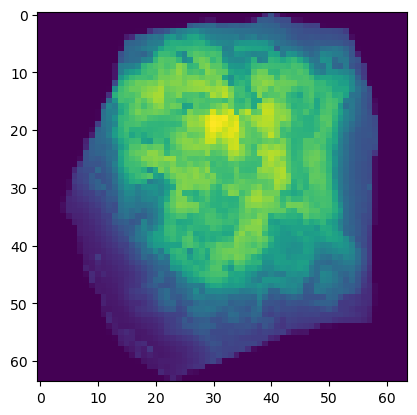

In [22]:
plt.imshow(res2[:,:,0])

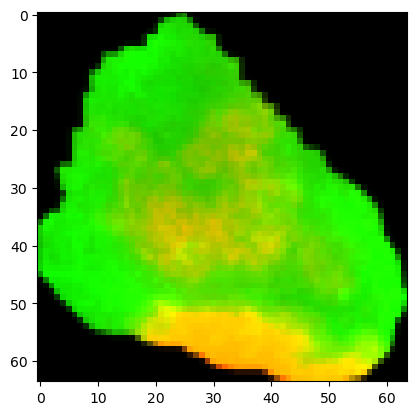

In [39]:
res2 = res[:,:,[-1,2]]
bb = res2[:,:,:].copy()
z = np.zeros((64, 64, 1),dtype = bb.dtype)
out = np.concatenate((bb,z),axis=2) # Or np.dstack((a,z))

### transfer to 256 scale with save behavior
thresh = np.quantile(out, 0.95, axis=(0,1))#.shape
# cap
out[:,:,0][out[:,:,0] > thresh[0]] = thresh[0]
out[:,:,1][out[:,:,1] > thresh[1]] = thresh[1]
# to 256
out[:,:,0] = (out[:,:,0] / thresh[0]) * 255
out[:,:,1] = (out[:,:,1] / thresh[1]) * 255

img8 = (out).astype('uint8')
plt.imshow(img8)

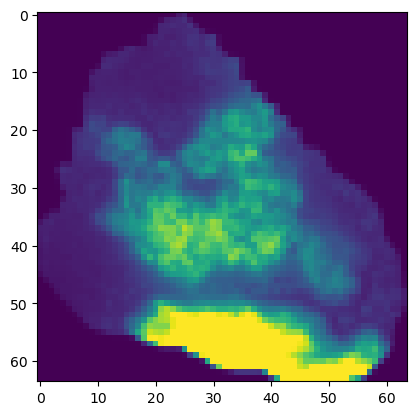

In [40]:
plt.imshow(img8[:,:,0])

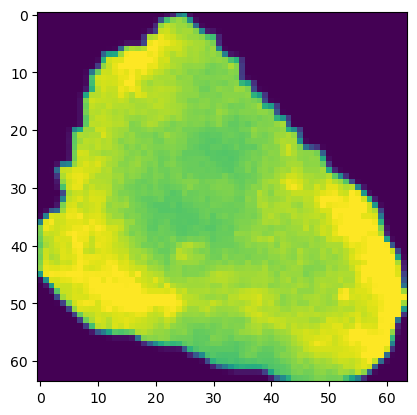

In [41]:
plt.imshow(img8[:,:,1])